There are two ways to use XGBoost algorithms:
* XGBoost scikit-learn compatible API
* k-fold cross-validation from the xgb library

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split

/usr/local/Cellar/python/3.7.2_2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.2_2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [5]:
df = pd.read_csv('./Data/chronic_kidney_disease_cleaned.csv', index_col = 0)
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,class
143,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
144,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
145,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
146,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
147,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [6]:
df.get_dtype_counts()

float64    14
object     11
dtype: int64

Because the ML algorithm only takes dtype as int, float or bool, the "object" dtype needs to be changed

In [67]:
numerical_cols = ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
categorical_cols = ['sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']

In [9]:
df[categorical_cols].get_dtype_counts()

float64     3
object     11
dtype: int64

In [10]:
df[categorical_cols] = df[categorical_cols].astype('category')

In [12]:
df.get_dtype_counts()

category    14
float64     11
dtype: int64

In [14]:
df[numerical_cols].isnull().sum()

age       9
bp       12
bgr      44
bu       19
sc       17
sod      87
pot      88
hemo     52
pcv      71
wc      106
rc      131
dtype: int64

In [15]:
df[categorical_cols].isnull().sum()

sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64

XGBoost can handle missing values. But here in the dataset, some columns have too many missing values, nearly one third of the entire data. Let me leave it here right now, but if the results are too bad, will come back to deal with missing values.

In [16]:
X, y = df.iloc[:, :-1], df.iloc[:,-1]

In [19]:
X = pd.get_dummies(X)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [37]:
import xgboost as xgb

xgb_model1 = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)

In [38]:
xgb_model1.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
       silent=True, subsample=1)

In [41]:
preds = xgb_model1.predict(X_test)

In [42]:
accuracy = float(np.sum(preds == y_test))/y_test.shape[0]
print(accuracy)

1.0


The accuracy is too good and I suspect something was wrong. After changing the random_state=1234, the accuracy became 0.975.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
xgb_model1 = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)
xgb_model1.fit(X,y)
preds = xgb_model1.predict(X_test)
accuracy = float(np.sum(preds == y_test))/y_test.shape[0]
print(accuracy)

0.975


Wow, this was credible. I hardly did any parameter tuning and the result was so good. But after I found this [link](https://mclguide.readthedocs.io/en/latest/sklearn/preprocessing.html#disqus_thread), this dataset was separated so well by PCA, which means it is easy to separate this subgroups.

Let me quickly follow the link above and conduct the **Principle Component Analysis** for this dataset.

In [62]:
numerical_cols

['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']

In [69]:
pca_cols = numerical_cols.copy()
pca_cols.append('class')

In [71]:
pca_cols

['age',
 'bp',
 'bgr',
 'bu',
 'sc',
 'sod',
 'pot',
 'hemo',
 'pcv',
 'wc',
 'rc',
 'class']

In [72]:
pca_df = df[pca_cols].dropna(axis=0, how='any')

In [73]:
# get two colors for different outcomes: red for ckd and green for notckd
targets = pca_df['class']
label_color = ['red' if i=='ckd' else 'green' for i in targets]
print (label_color)

['red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'gr

PCA is more suitable for numerical variables, thus only use the numerical features here.

In [74]:
pca_feature = pca_df.iloc[:, :-1]

In [47]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

/usr/local/Cellar/python/3.7.2_2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [76]:
pca = PCA(n_components=2)
pca.fit(pca_feature)

T = pca.transform(pca_feature) # transformed data
T = pd.DataFrame(T)

In [77]:
T.shape

(214, 2)

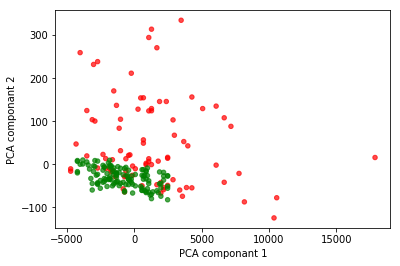

In [78]:
T.columns = ['PCA componant 1', 'PCA componant 2']
T.plot.scatter(x='PCA componant 1', y='PCA componant 2', marker='o', alpha=0.7, color = label_color)
plt.show()